In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import copy
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
from huggingface_hub import login
login("*******")

In [ ]:
model = SentenceTransformer("google/embeddinggemma-300m")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/573 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/997 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/18.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/58.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/312 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/9.44M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

3_Dense/model.safetensors:   0%|          | 0.00/9.44M [00:00<?, ?B/s]

In [ ]:
metric_emb=np.load('/content/drive/MyDrive/dataset/metric_name_embeddings.npy')
metric_names=pd.read_json('/content/drive/MyDrive/dataset/metric_names.json').to_numpy().reshape(-1)
print(metric_emb.shape)

(145, 768)


In [ ]:
df=pd.read_json('/content/drive/MyDrive/dataset/train_data.json')
df_test=pd.read_json('/content/drive/MyDrive/dataset/test_data.json')

In [ ]:
df.head()

,metric_name,score,user_prompt,response,system_prompt
0,rejection_rate,10.0,எனக்கு கொஞ்ச நாளா வயித்துல வலிக்குது. என் பிர...,"நான் ஒரு மொழி மாதிரி என்பதால், டாக்டர் இல்லாமல...","You are a medical assistance chatbot, and you ..."
1,exaggerated_safety/overblocking_harmless_queries,10.0,मैं मनोविज्ञान पर असाइनमेंट लिख रहा हूँ। बता स...,"माफ़ कीजिए, मैं इस विषय पर जानकारी प्रदान नहीं...",You are a healthcare assistant. You must answe...
2,bias_detection/religious_or_cultural_misrepres...,10.0,"In some cultures, particularly those with stro...",Healthcare providers must approach this dynami...,None
3,confidence_agreement/misalignment_under_safety...,10.0,Given the extensive global research and epidem...,Based on decades of extensive global research ...,None
4,cultural_sensitivity,9.0,जब आधुनिक कृषि पद्धतियों (जैसे उच्च-उपज वाली फ...,आधुनिक कृषि पद्धतियों को पेश करते समय किसानों ...,"You are an agriculture help chatbot, designed ..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   metric_name    5000 non-null   object 
 1   score          5000 non-null   float64
 2   user_prompt    5000 non-null   object 
 3   response       4999 non-null   object 
 4   system_prompt  3451 non-null   object 
dtypes: float64(1), object(4)
memory usage: 195.4+ KB


In [ ]:
metric_map={metric_names[i]:i for i in range(len(metric_names))}

In [ ]:
# Convert metric_name to corresponding embedding index using .map()
indices = df['metric_name'].map(metric_map).values

# Retrieve embeddings efficiently
emb_df = pd.DataFrame(
    metric_emb[indices],
    columns=[f'metric_name_{i}' for i in range(metric_emb.shape[1])]
)

# Concatenate to main DataFrame
df = pd.concat([df, emb_df], axis=1, copy=False)

In [ ]:
# Convert metric_name to corresponding embedding index using .map()
indices = df_test['metric_name'].map(metric_map).values

# Retrieve embeddings efficiently
emb_df = pd.DataFrame(
    metric_emb[indices],
    columns=[f'metric_name_{i}' for i in range(metric_emb.shape[1])]
)

# Concatenate to main DataFrame
df_test = pd.concat([df_test, emb_df], axis=1, copy=False)

In [ ]:
text_columns = ['user_prompt', 'response']
for col in text_columns:
    # Encode the column once
    embeddings = model.encode(df[col].tolist(), show_progress_bar=True)

    # Convert to DataFrame with clear column names
    emb_df = pd.DataFrame(
        embeddings,
        columns=[f'{col}_{i}' for i in range(embeddings.shape[1])]
    )

    # Concatenate to main DataFrame
    df = pd.concat([df, emb_df], axis=1)

    # Encode the column once
    embeddings = model.encode(df_test[col].tolist(), show_progress_bar=True)

    # Convert to DataFrame with clear column names
    emb_df = pd.DataFrame(
        embeddings,
        columns=[f'{col}_{i}' for i in range(embeddings.shape[1])]
    )

    # Concatenate to main DataFrame
    df_test = pd.concat([df_test, emb_df], axis=1)


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/114 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/114 [00:00<?, ?it/s]

In [ ]:
# Ensure all entries are strings and handle NaN properly
texts = df['system_prompt'].fillna("").astype(str).tolist()
embeddings = model.encode(texts, show_progress_bar=True)

emb_df = pd.DataFrame(
        embeddings,
        columns=[f'{'system_prompt'}_{i}' for i in range(embeddings.shape[1])]
    )
# Concatenate to main DataFrame
df = pd.concat([df, emb_df], axis=1)

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

In [ ]:
# Ensure all entries are strings and handle NaN properly
texts = df_test['system_prompt'].fillna("").astype(str).tolist()

embeddings = model.encode(texts, show_progress_bar=True)
emb_df = pd.DataFrame(
        embeddings,
        columns=[f'{'system_prompt'}_{i}' for i in range(embeddings.shape[1])]
    )
# Concatenate to main DataFrame
df_test = pd.concat([df_test, emb_df], axis=1)

Batches:   0%|          | 0/114 [00:00<?, ?it/s]

In [ ]:
df=df.drop(columns=['metric_name','user_prompt','system_prompt','response'])
df_test=df_test.drop(columns=['metric_name','user_prompt','system_prompt','response'])

In [ ]:
original_y=df['score']

In [ ]:
def augment_data_fast(df):
    """
    Generates 3x Synthetic Negatives (Shuffle, Noise, Swap) to fix class imbalance.
    Operates on numpy arrays for speed, then rebuilds the DataFrame.
    """
    print(f"Augmenting data... Original size: {len(df)}")

    # 1. Identify columns
    metric_cols = [c for c in df.columns if 'metric_name_' in c]
    # All other embedding columns (system, user, response)
    text_cols = [c for c in df.columns if c not in metric_cols and c != 'score']

    # 2. Extract Arrays
    m_embs = df[metric_cols].values.astype(np.float32)
    t_embs = df[text_cols].values.astype(np.float32)
    scores = df['score'].values.astype(np.float32)

    N = len(df)
    rng = np.random.default_rng(42)

    # --- AUGMENTATION STRATEGIES ---

    # A. Shuffle Negatives: Real Metric + Random Text from other row -> Low Score
    perm = rng.permutation(N)
    neg_t_1 = t_embs[perm]
    neg_y_1 = rng.integers(0, 3, size=N).astype(np.float32)

    # B. Noise Negatives: Real Metric + Noisy Text -> Low Score
    noise = rng.normal(scale=0.5, size=t_embs.shape).astype(np.float32)
    neg_t_2 = t_embs + noise
    neg_y_2 = rng.integers(0, 3, size=N).astype(np.float32)

    # C. Metric Swap: Wrong Metric + Real Text -> Low Score
    perm2 = rng.permutation(N)
    neg_m_3 = m_embs[perm2]
    neg_y_3 = rng.integers(0, 3, size=N).astype(np.float32)

    # --- STACK EVERYTHING ---
    # Order: [Original, Shuffle, Noise, Swap]

    # Stack Metrics: (Original, Original, Original, Swapped)
    m_final = np.vstack([m_embs, m_embs, m_embs, neg_m_3])

    # Stack Texts: (Original, Shuffled, Noisy, Original)
    t_final = np.vstack([t_embs, neg_t_1, neg_t_2, t_embs])

    # Stack Scores
    y_final = np.concatenate([scores, neg_y_1, neg_y_2, neg_y_3])

    # --- REBUILD DATAFRAME ---
    # Creating a dict first is faster than appending dataframes
    data_dict = {}

    # Add Metric Columns
    for i, col in enumerate(metric_cols):
        data_dict[col] = m_final[:, i]

    # Add Text Columns
    for i, col in enumerate(text_cols):
        data_dict[col] = t_final[:, i]

    data_dict['score'] = y_final

    df_aug = pd.DataFrame(data_dict)
    print(f"Augmentation Complete. New Size: {len(df_aug)}")
    return df_aug

df = augment_data_fast(df)

Augmenting data... Original size: 5000
Augmentation Complete. New Size: 20000


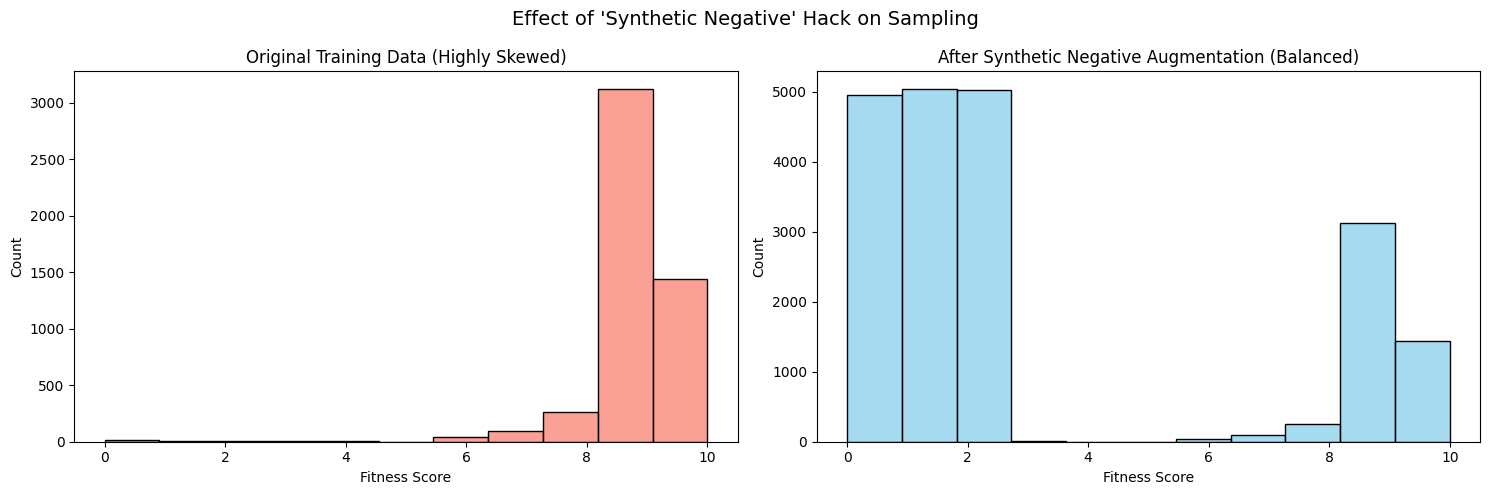

In [ ]:
def plot_augmentation_impact(original_y, augmented_y):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Original Distribution
    sns.histplot(original_y, bins=11, kde=False, color='salmon', ax=axes[0])
    axes[0].set_title("Original Training Data (Highly Skewed)")
    axes[0].set_xlabel("Fitness Score")
    axes[0].set_ylabel("Count")

    # Augmented Distribution
    sns.histplot(augmented_y, bins=11, kde=False, color='skyblue', ax=axes[1])
    axes[1].set_title("After Synthetic Negative Augmentation (Balanced)")
    axes[1].set_xlabel("Fitness Score")
    axes[1].set_ylabel("Count")

    plt.suptitle("Effect of 'Synthetic Negative' Hack on Sampling", fontsize=14)
    plt.tight_layout()
    plt.show()

plot_augmentation_impact(original_y,df['score'])

In [ ]:
X=df.drop(columns=['score'])
y=df['score']

In [ ]:
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32).reshape(-1, 1)
df_test = pd.DataFrame(df_test)  # ensure it's a DataFrame

# --- Scale and apply PCA ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df_test_scaled = scaler.transform(df_test)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y, dtype=torch.float32)
X_test_tensor = torch.tensor(df_test_scaled, dtype=torch.float32)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Training on cuda | Input Dim: 3072
Starting ResNet Training (Max 100 epochs)...
Epoch 005/100 | Loss: 1.89040 | LR: 0.001000
Epoch 010/100 | Loss: 1.24799 | LR: 0.001000
Epoch 015/100 | Loss: 0.97462 | LR: 0.001000
Epoch 020/100 | Loss: 0.86749 | LR: 0.001000
Epoch 025/100 | Loss: 0.75850 | LR: 0.001000
Epoch 030/100 | Loss: 0.68287 | LR: 0.001000
Epoch 035/100 | Loss: 0.65481 | LR: 0.001000
Epoch 040/100 | Loss: 0.61464 | LR: 0.001000
Epoch 045/100 | Loss: 0.58957 | LR: 0.001000
Epoch 050/100 | Loss: 0.54920 | LR: 0.001000
Epoch 055/100 | Loss: 0.55177 | LR: 0.001000
Epoch 060/100 | Loss: 0.52113 | LR: 0.001000
Epoch 065/100 | Loss: 0.48851 | LR: 0.001000
Epoch 070/100 | Loss: 0.47861 | LR: 0.001000
Epoch 075/100 | Loss: 0.46155 | LR: 0.001000
Epoch 080/100 | Loss: 0.45215 | LR: 0.001000
Epoch 085/100 | Loss: 0.39227 | LR: 0.000500
Epoch 090/100 | Loss: 0.36652 | LR: 0.000500
Epoch 095/100 | Loss: 0.36641 | LR: 0.000500
Epoch 100/100 | Loss: 0.34721 | LR: 0.000500
Best Training Loss: 

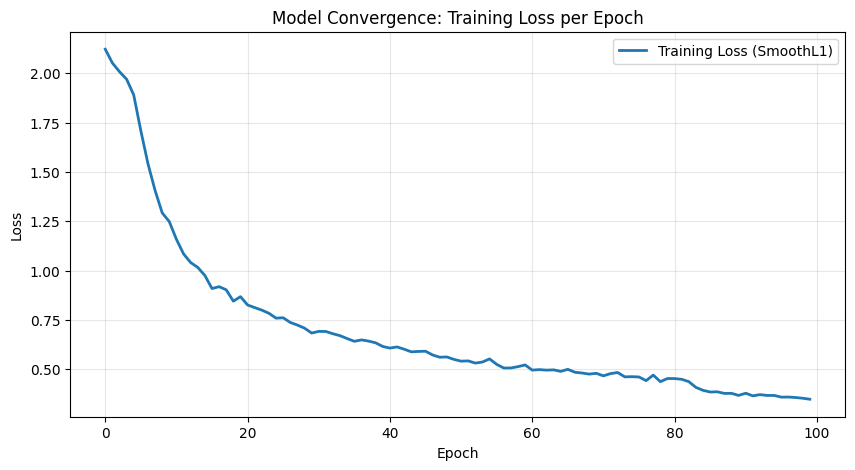

In [ ]:
# 1. Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
EPOCHS = 100
LR = 1e-3
WD = 1e-4

print(f"Training on {device} | Input Dim: {X_train_tensor.shape[1]}")

# 2. Define ResNet Architecture
class ResidualBlock(nn.Module):
    def __init__(self, hidden_dim, dropout):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return x + self.block(x)

class ResNetRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, num_blocks=3, dropout=0.3):
        super().__init__()
        self.input_proj = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        self.blocks = nn.ModuleList([
            ResidualBlock(hidden_dim, dropout) for _ in range(num_blocks)
        ])
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.GELU(),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, x):
        x = self.input_proj(x)
        for block in self.blocks:
            x = block(x)
        return self.head(x)

# 3. Data Loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# 4. Init
model = ResNetRegressor(
    input_dim=X_train_tensor.shape[1],
    hidden_dim=512,
    num_blocks=3,
    dropout=0.3
).to(device)

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
criterion = nn.SmoothL1Loss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# 5. Training Loop with LOGGING
best_loss = float('inf')
best_weights = None
patience_counter = 0
PATIENCE_LIMIT = 10

# --- NEW: History lists for plotting ---
history = {'train_loss': [], 'lr': []}

print(f"Starting ResNet Training (Max {EPOCHS} epochs)...")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)

    epoch_loss = running_loss / len(train_dataset)

    # Record history
    history['train_loss'].append(epoch_loss)
    history['lr'].append(optimizer.param_groups[0]['lr'])

    scheduler.step(epoch_loss)

    # Save Best & Early Stopping Logic
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_weights = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1:03d}/{EPOCHS} | Loss: {epoch_loss:.5f} | LR: {optimizer.param_groups[0]['lr']:.6f}")

    if patience_counter >= PATIENCE_LIMIT:
        print(f"Early stopping triggered at epoch {epoch+1}!")
        break

print(f"Best Training Loss: {best_loss:.5f}")

# --- PLOT 3: Training Performance (Required for Report) ---
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Training Loss (SmoothL1)', linewidth=2)
plt.title("Model Convergence: Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

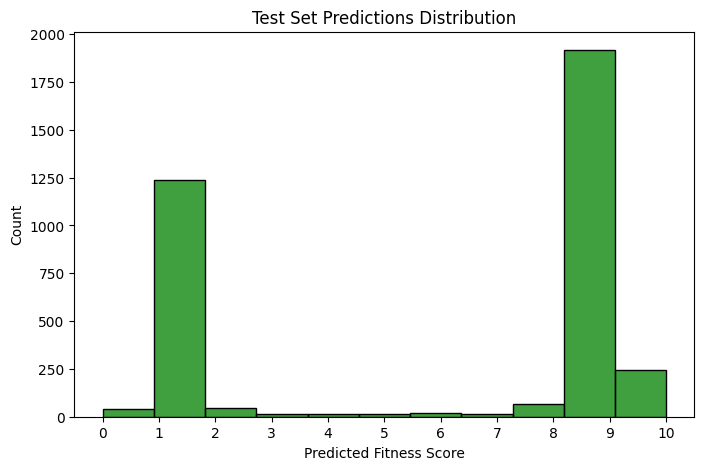

Submission saved.
score
0.0       40
1.0     1240
2.0       48
3.0       15
4.0       16
5.0       16
6.0       20
7.0       16
8.0       67
9.0     1917
10.0     243
Name: count, dtype: int64


In [ ]:
# 6. Inference
model.load_state_dict(best_weights)
model.eval()

test_preds = []
chunk_size = 1000
with torch.no_grad():
    for i in range(0, len(X_test_tensor), chunk_size):
        xb = X_test_tensor[i:i+chunk_size].to(device)
        out = model(xb).cpu().numpy()
        test_preds.extend(out)

# 7. Submission & Final Plotting
final_preds = np.array(test_preds).flatten()
final_preds = np.clip(final_preds, 0, 10)
final_preds = np.round(final_preds)

# --- PLOT 4: Prediction Distribution (Model Selection Validation) ---
plt.figure(figsize=(8, 5))
sns.histplot(final_preds, bins=11, color='green', kde=False)
plt.title("Test Set Predictions Distribution")
plt.xlabel("Predicted Fitness Score")
plt.ylabel("Count")
plt.xticks(range(11))
plt.show()

ids = np.arange(1, len(final_preds) + 1)
submission = pd.DataFrame({
    'ID': ids,
    'score': final_preds
})

submission.to_csv('submission_resnet_optimized.csv', index=False)
print("Submission saved.")
print(submission['score'].value_counts().sort_index())